In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('manipulated_data.csv')

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

data.head()



,date,energy_production,humidity,solar_irradiance,temperature
0,2022-01-01,171965.00,67.903562,671.539150,21.139696
1,2022-01-02,171495.50,64.823080,700.916586,18.734613
2,2022-01-03,183128.00,66.413694,737.124585,22.911354
3,2022-01-04,193922.75,68.619712,784.792551,19.992095
4,2022-01-05,196215.20,59.372813,750.477917,25.732163


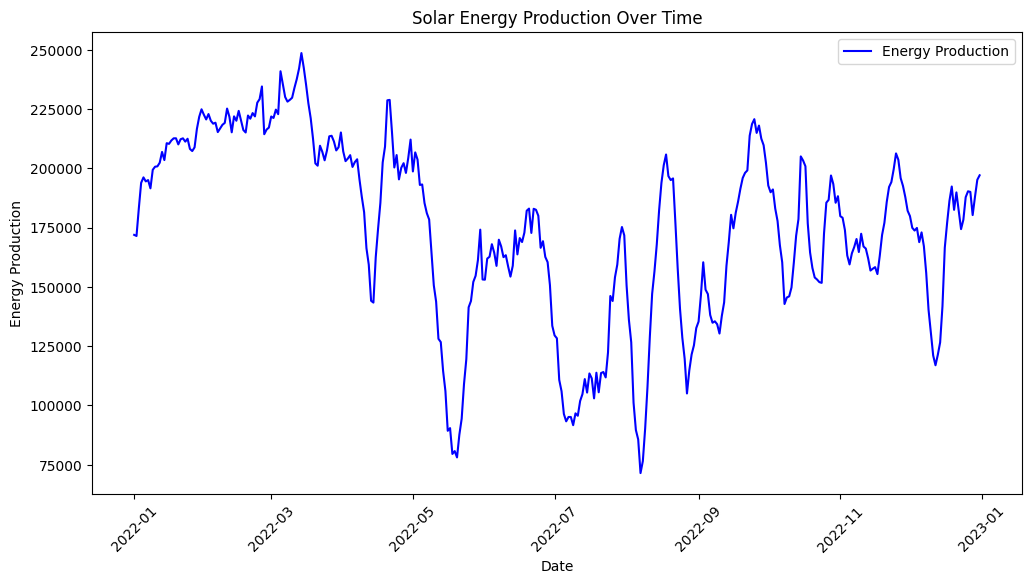

In [3]:
# Plot solar energy production over time
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['energy_production'], label='Energy Production', color='blue')
plt.title('Solar Energy Production Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.legend()
plt.xticks(rotation=45)
plt.show()

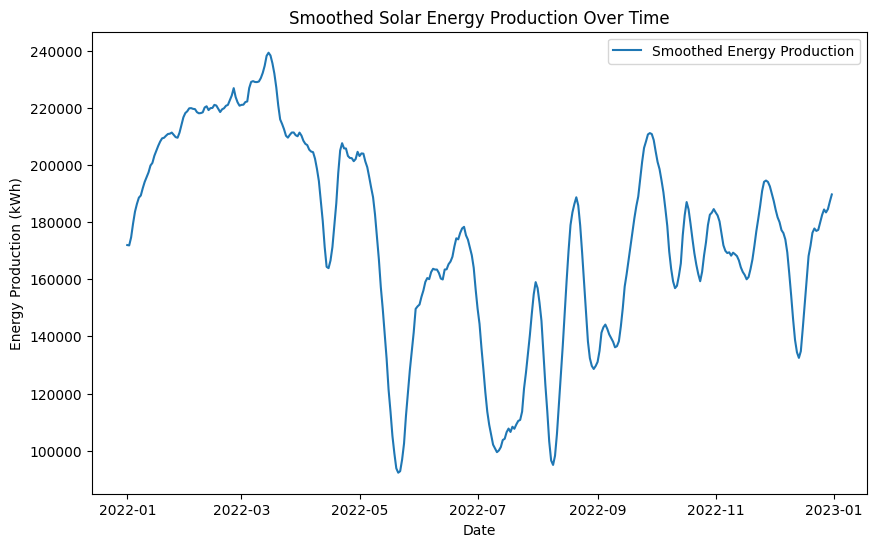

In [4]:
# Apply a moving average with a window size of 7 days
# data['energy_production'] = data['energy_production'].rolling(window=7, min_periods=1).mean()
data['energy_production'] = data['energy_production'].ewm(span=7, adjust=False).mean()

# Plot the smoothed energy production over time
plt.figure(figsize=(10,6))
plt.plot(data['date'], data['energy_production'], label='Smoothed Energy Production')
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Smoothed Solar Energy Production Over Time')
plt.legend()
plt.show()

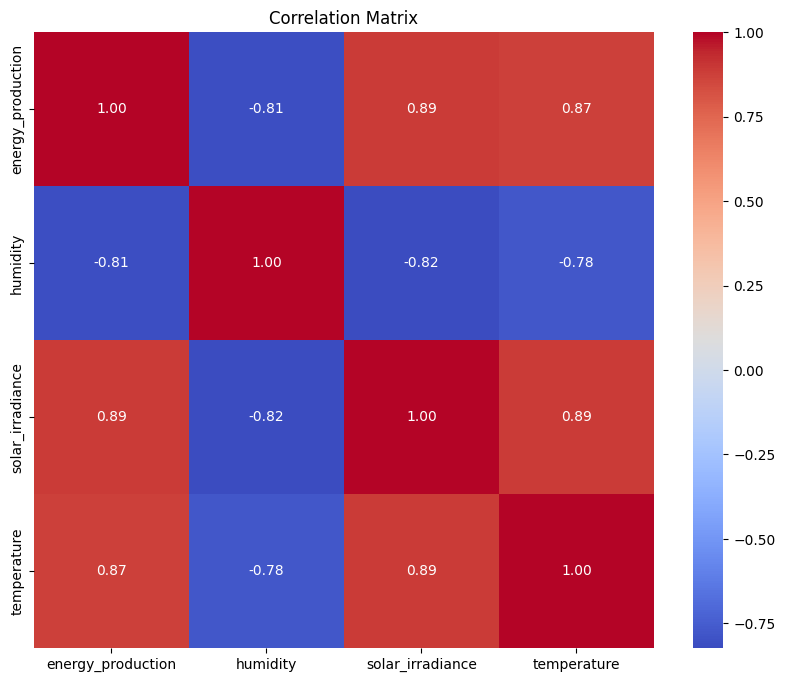

In [5]:
# Filter out non-numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=[np.number])

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

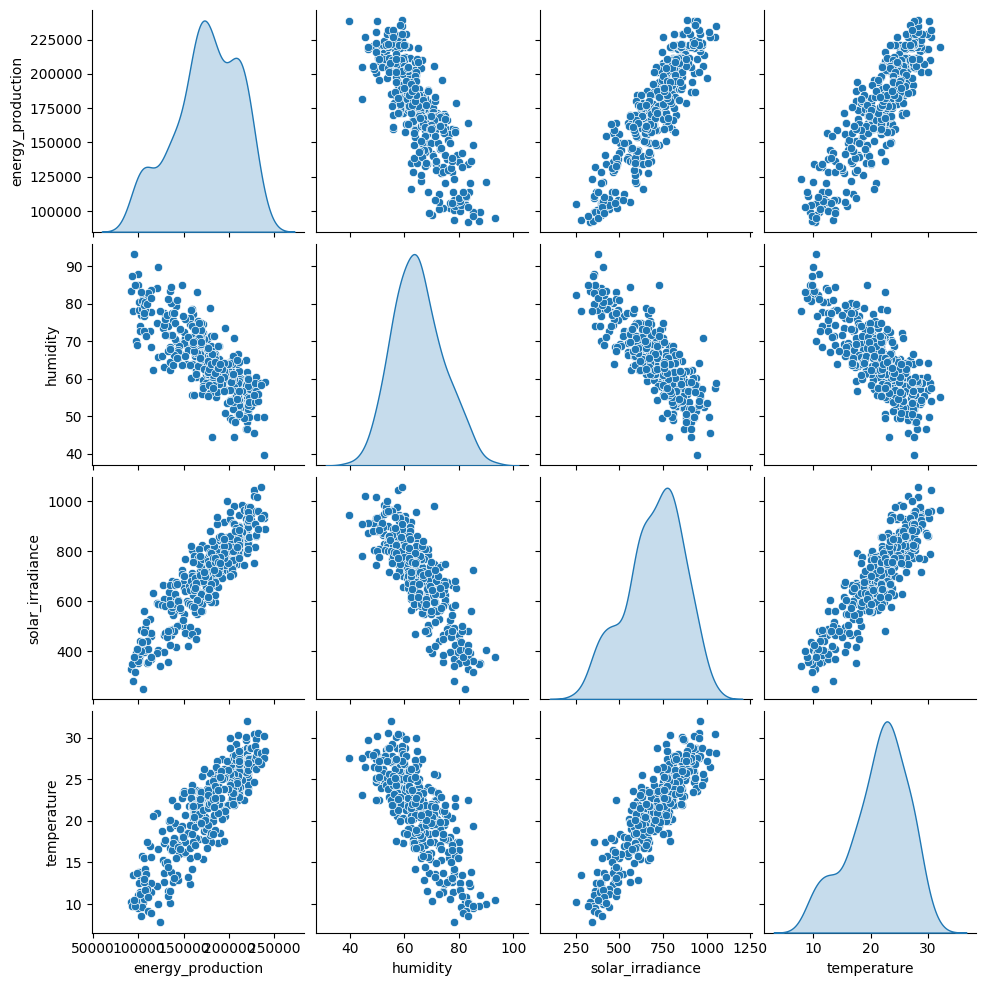

In [6]:
# Plot pairwise relationships between features and target variable
sns.pairplot(data, diag_kind='kde')
plt.show()

In [7]:
# Select the features and target variable
X = data[['humidity', 'solar_irradiance', 'temperature']]
y = data['energy_production']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the KNN regressor
knn_model = KNeighborsRegressor(n_neighbors=5)  # You can adjust 'n_neighbors' as needed
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

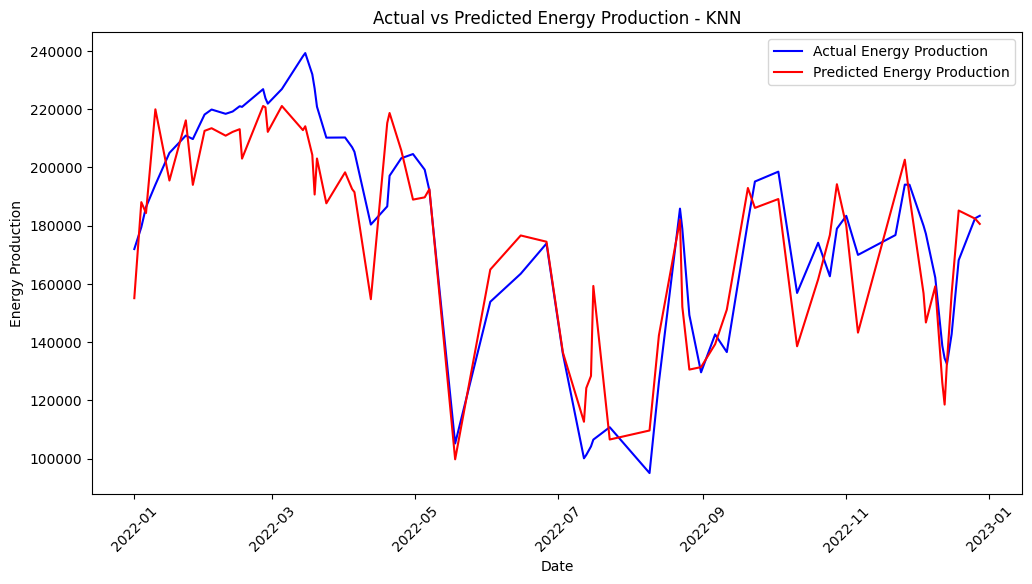

In [8]:
# Merge predictions with test data for visualization
test_results = X_test.copy()
test_results['actual'] = y_test
test_results['predicted'] = y_pred
test_results['date'] = data.loc[X_test.index, 'date']  # Match dates with test set index

# Sort by date for proper plotting
test_results = test_results.sort_values(by='date')

# Plot actual vs predicted energy production
plt.figure(figsize=(12, 6))
plt.plot(test_results['date'], test_results['actual'], label='Actual Energy Production', color='blue')
plt.plot(test_results['date'], test_results['predicted'], label='Predicted Energy Production', color='red')
plt.title('Actual vs Predicted Energy Production - KNN')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.legend()
plt.xticks(rotation=45)
plt.show()

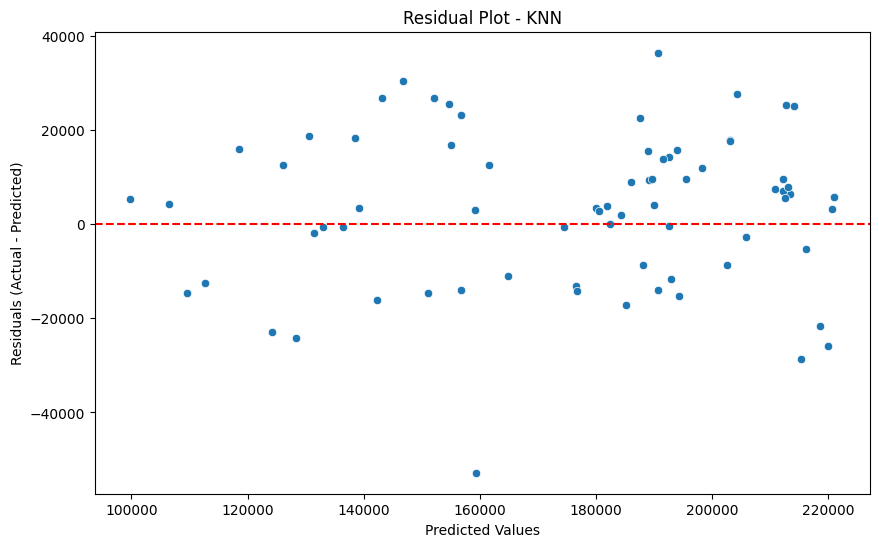

In [9]:
# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot - KNN')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

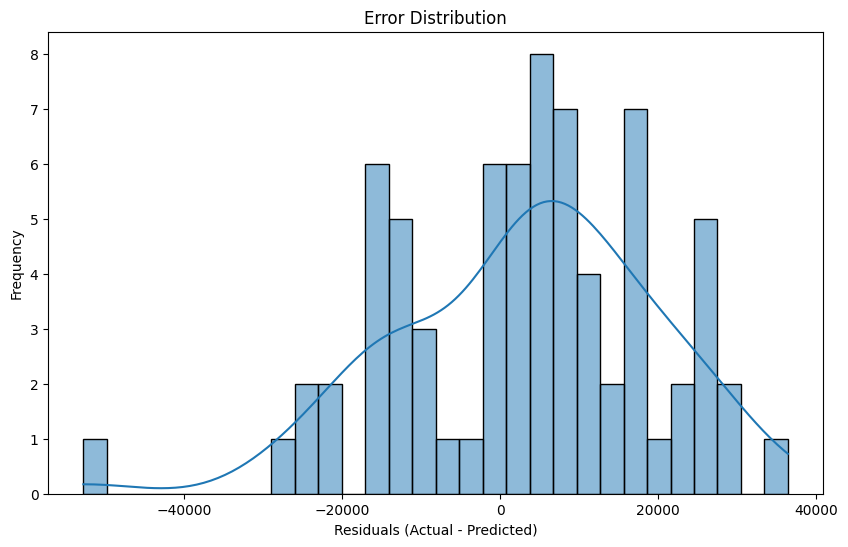

In [10]:
# Plot the error distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Error Distribution')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

MAE: 13339.739347121118
RMSE: 16533.39460748867
R2 Score: 0.8058439886310382


In [12]:
# Calculate accuracy in percentages
accuracy_percentage = r2 * 100
print(f'Accuracy: {accuracy_percentage:.2f}%')

Accuracy: 80.58%
